In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import pickle
import cvxpy 
from cvxpy import *
from  sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import sys
import networkx as nx
from robust_KO_learning import *
from preprocessing import *
from gene_sets import *
import scanpy as sc

### Load the data and parse metadata

In [2]:
def snapshots_from_df(df):

    strains = ['wt','icar','phlf','nand']
    tps = ['5','18']
    temps = ['30','37']
    inducers = ['00','10','01','11']

    # create a dictionary where you specify strain, temp, and inducers as keys to grab the snapshot matrices
    snapshot_dict = {}
    for strain in strains: 
        snapshot_dict[strain] = {}
        for temp in temps: 
            snapshot_dict[strain][temp] = {}
            for inducer in inducers: 
                snapshot_dict[strain][temp][inducer] = {} # keys are to be Yf and Yp
                # get substring of colname that identifies the group (so everything except rep number)
                yp_colname = strain + '_' + inducer + temp + tps[0]
                # get list of indices that correspond to this group (in short, grabbing inds for all replicates)
                yp_col_inds = [ii for ii, this_col in enumerate(list(df.columns)) if yp_colname in this_col]
                snapshot_dict[strain][temp][inducer]['Yp'] = np.array(df.iloc[:,yp_col_inds])
                # do the same for the 18 hours timepoint i.e. Yf
                yf_colname = strain + '_' + inducer + temp + tps[1]
                yf_col_inds = [ii for ii, this_col in enumerate(list(df.columns)) if yf_colname in this_col]
                snapshot_dict[strain][temp][inducer]['Yf'] = np.array(df.iloc[:,yf_col_inds])
                
    return snapshot_dict

def get_unpaired_samples(df):
    # filter the samples that don't have a timepoint pair due to low sequencing depth
    unpaired_samples = []
    for sample in df.columns: 
        if '5' in sample:
            if sample.replace('5','18') not in df.columns:
                unpaired_samples.append(sample)
        elif '18' in sample: 
            if sample.replace('18','5') not in df.columns:
                unpaired_samples.append(sample)
    return unpaired_samples

In [157]:
df_tpm_filter = pd.read_csv('data/TPM_matrix_NAND.csv')

In [158]:
df_tpm_filter

,gene,icar_003018R0,icar_003018R1,icar_003018R2,icar_003018R3,icar_00305R0,icar_00305R1,icar_00305R2,icar_00305R3,icar_003718R0,...,wt_11305R0,wt_11305R1,wt_11305R2,wt_11305R3,wt_113718R0,wt_113718R2,wt_113718R3,wt_11375R0,wt_11375R2,wt_11375R3
0,Actuator_YFP,10115.061060,11232.252510,10527.270210,11552.779930,6752.524914,7016.320503,7493.584349,7423.732158,2711.914646,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,CamR,325.947183,276.530481,293.290001,261.721376,1088.227900,1227.385075,1186.331403,967.916222,941.982846,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Sensor_AraC,88.379303,89.984175,84.565133,82.659435,191.094788,225.774178,219.244125,216.835932,33.070490,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Sensor_LacI,37.102941,36.234097,35.618156,31.585897,77.682784,85.723283,86.893857,94.898923,17.105821,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Sensor_LuxR,20.941983,23.505673,17.518567,17.057920,74.359004,79.304905,72.011351,66.142353,7.172955,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4077,insD1,20.638923,20.895919,19.174164,19.026040,13.542972,14.225412,16.041770,15.103051,16.915471,...,13.468971,13.587530,15.986483,15.599479,26.981325,32.134232,31.203935,26.445513,27.857631,22.789040
4078,insQ,138.060608,147.364439,129.395535,141.737731,42.998426,49.968575,48.808634,45.485136,17.319554,...,50.656829,48.298156,50.832056,57.090338,55.875507,34.139916,43.146298,79.426610,59.883690,63.919813
4079,insJ,3.041455,3.260012,5.186384,2.365770,4.115042,3.437134,4.427270,3.905374,1.314584,...,6.364879,4.515885,4.962816,3.198729,3.999686,3.522518,7.448741,2.192224,4.029217,4.407378
4080,insK,1.242284,0.499333,1.059191,0.724725,2.979585,0.631755,1.808322,2.392729,0.000000,...,2.022019,2.420928,1.796717,2.099769,3.063140,1.438775,1.140916,0.671561,1.939618,1.869435


In [159]:
obs_df = pd.DataFrame([],columns=['strain','temp','time','replicate','inducers','ara','iptg'])
for obs in df_tpm_filter.columns[1:]:
    
    obs_split = obs.split('_')
    strain = obs_split[0]
    replicate = obs_split[1].split('R')[1]
    
    if '00' in obs_split[1]: # get inducer conditions (might be important to grab the actual concentration)
        inducers = '00'
        ara = '0'
        iptg = '0'
    elif '01' in obs_split[1]:
        inducers = '01'
        ara = '0'
        iptg = '1'
    elif '10' in obs_split[1]:
        inducers = '10'
        ara = '1'
        iptg = '0'
    elif '11' in obs_split[1]:
        inducers = '11'
        ara = '1'
        iptg = '1'
        
    if '30' in obs_split[1]: # get temperature in degC
        temp = '30'
    elif '37' in obs_split[1]:
        temp = '37'
        
    if '5' in obs_split[1]: # get time in hours
        time = '5'
    elif '18' in obs_split[1]:
        time = '18'
    
    temp_df = pd.DataFrame([strain,temp,time,replicate,inducers,ara,iptg]).T
    temp_df.columns = obs_df.columns
    obs_df = obs_df.append(temp_df,ignore_index=True)


Model the bulk cell space manifold

In [160]:
adata = sc.AnnData(X=df_tpm_filter.iloc[:,1:].T.reset_index(drop=True),obs=obs_df)
adata.var = pd.DataFrame(df_tpm_filter.gene)
adata.var.index = list(df_tpm_filter.gene)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [161]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

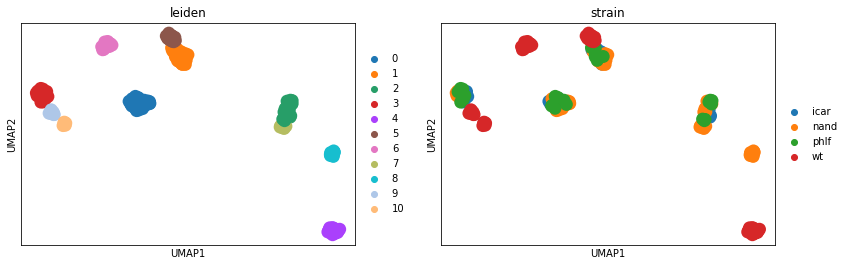

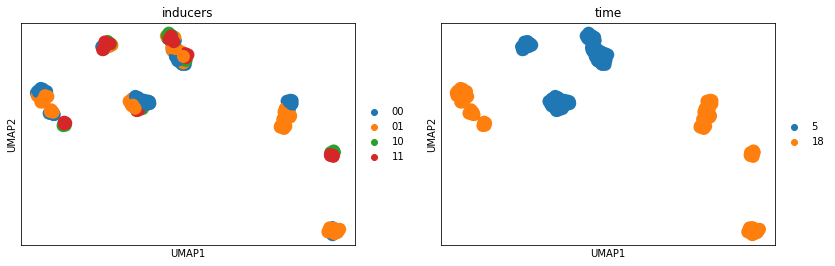

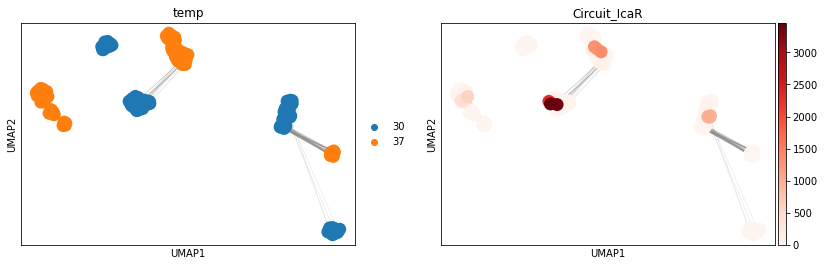

In [163]:
sc.pl.umap(adata,color=['leiden','strain'])
sc.pl.umap(adata,color=['inducers','time'])
sc.pl.umap(adata,color=['temp','Circuit_IcaR'],edges=True,cmap='Reds')

The above disjoint graphs motivate analysis of each (time, temp) pair separately

In [164]:
bdata = adata[adata.obs.time.isin(['5']) & adata.obs.temp.isin(['37'])].copy()

In [165]:
sc.pp.pca(bdata)
sc.pp.neighbors(bdata)
sc.tl.leiden(bdata)
sc.tl.umap(bdata)

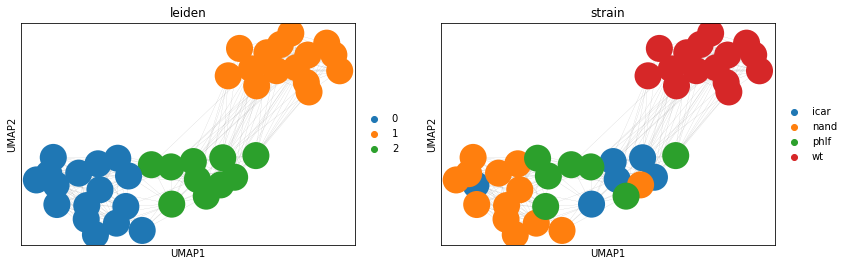

In [166]:
sc.pl.umap(bdata,color=['leiden','strain'],edges=True)

Let's try to model the gene space manifold

In [167]:
adata = sc.AnnData(X=df_tpm_filter.iloc[:,1:].reset_index(drop=True))
sc.pp.scale(adata)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [168]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

In [169]:
adata.obs['is_circuit'] = [1]*13 + [0]*(adata.n_obs-13)

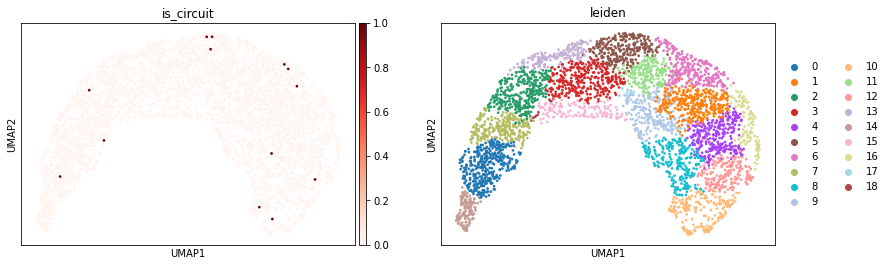

In [170]:
sc.pl.umap(adata,color=['is_circuit','leiden'],cmap='Reds')

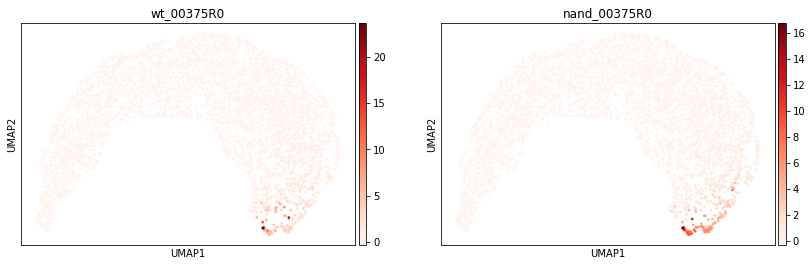

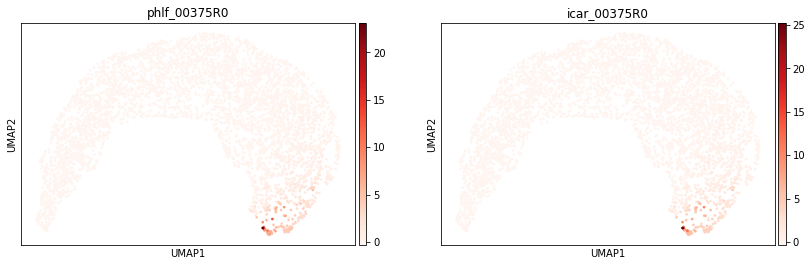

In [175]:
sc.pl.umap(adata,color=['wt_00375R0','nand_00375R0'],cmap='Reds')
sc.pl.umap(adata,color=['phlf_00375R0','icar_00375R0'],cmap='Reds')

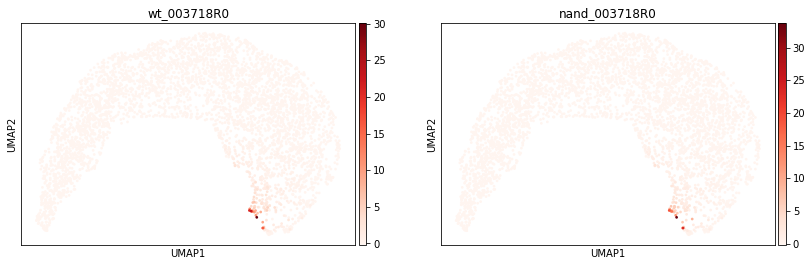

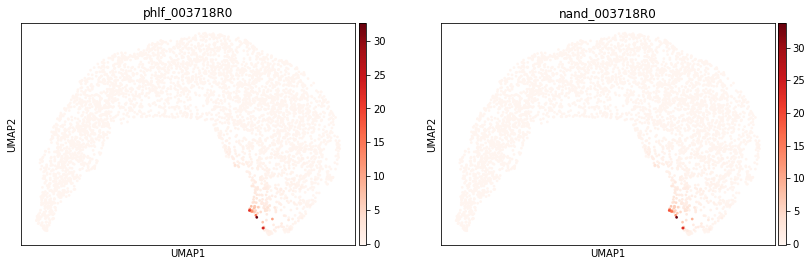

In [176]:
sc.pl.umap(adata,color=['wt_003718R0','nand_003718R0'],cmap='Reds')
sc.pl.umap(adata,color=['phlf_003718R0','nand_003718R0'],cmap='Reds')